In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from collections import defaultdict
from common import Fonts, Images, NWSL, Colors, add_twitter_handle

In [2]:
df = pd.read_csv("nwsl/2023_2024_movement.csv")
df

,player,team_old,team_new
0,Abby Dahlkemper,SD,SD
1,Abby Erceg,LOU,LOU
2,Abby Smith,NJNY,NJNY
3,Addie McCain,CHI,NaN
4,Addisyn Merrick,KCC,UTA
...,...,...,...
421,Wang Shuang,LOU,NaN
422,Yazmeen Ryan,NJNY,NJNY
423,Yuki Nagasato,CHI,HOU
424,Yuuka Kurosaki,NaN,LOU


In [3]:
teams = list(filter(lambda x:  isinstance(x, str), df["team_new"].unique()))
teams

['SD',
 'LOU',
 'NJNY',
 'UTA',
 'ORL',
 'KCC',
 'RGN',
 'BAY',
 'LA',
 'CHI',
 'HOU',
 'WAS',
 'NC',
 'POR']

In [4]:
retained = (
    df[df["team_old"] == df["team_new"]]
    .groupby("team_new")
    .agg(count=("team_new", "count"))
    .sort_values("count", ascending=False)
    .reset_index()
)
retained.loc[len(retained.index)] = ['BAY', 0]  
retained.loc[len(retained.index)] = ['UTA', 0]  
retained

,team_new,count
0,NC,22
1,LA,21
2,ORL,21
3,HOU,20
4,NJNY,20
5,RGN,20
6,KCC,19
7,POR,17
8,LOU,16
9,WAS,16


In [5]:
traded = (
    df[(df["team_old"] != df["team_new"]) & df["team_old"] & df["team_new"]]
    .groupby(["team_new", "team_old"])
    .agg(count=("team_new", "count"))
    .reset_index()
)
traded

,team_new,team_old,count
0,BAY,CHI,1
1,BAY,HOU,2
2,BAY,KCC,1
3,BAY,LA,1
4,BAY,NC,3
5,BAY,POR,1
6,BAY,RGN,1
7,BAY,SD,1
8,BAY,WAS,1
9,CHI,HOU,1


In [6]:
# Calculate the spokes coming out of each team's circle that isn't to
# another team that is directly adjacent
indices = {}
for i, team in retained.iterrows():
    indices[team["team_new"]] = i
    
spokes = defaultdict(int)
for i, team in traded.iterrows():
    new = team["team_new"]
    old = team["team_old"]
    if (indices[new] - indices[old]) % len(retained.index) != 1:
        spokes[new] += 1
        spokes[old] += 1
        
spokes

defaultdict(int,
            {'BAY': 8,
             'HOU': 8,
             'KCC': 9,
             'LA': 6,
             'NC': 7,
             'POR': 6,
             'RGN': 5,
             'SD': 8,
             'WAS': 7,
             'CHI': 9,
             'ORL': 4,
             'LOU': 7,
             'NJNY': 6,
             'UTA': 8})

In [7]:
def get_sort(a, b):
    a_val = retained.index[retained["team_new"] == a][0]
    b_val = retained.index[retained["team_new"] == b][0]
    return a_val if a_val > b_val else a_val + len(retained.index)


def get_angles(old, new):
    """Returns a pair of angle offsets from the center for old and new"""

    # Find which spoke is associated with the old team
    df_old = traded[(traded["team_old"] == old) | (traded["team_new"] == old)]
    df_old["indices_offset"] = df_old.apply(
        lambda x: (indices[x["team_new"]] - indices[x["team_old"]])
        % len(retained.index),
        axis=1,
    )
    df_old = df_old[df_old["indices_offset"] > 1]
    df_old["sort_new"] = df_old["team_new"].apply(
        lambda x: get_sort(x, old) if x != old else 0
    )
    df_old["sort_old"] = df_old["team_old"].apply(
        lambda x: get_sort(x, old) + 0.5 if x != old else 0
    )
    df_old["sort"] = df_old["sort_new"] + df_old["sort_old"]

    df_old = df_old.sort_values("sort").reset_index()
    old_spoke = a_val = df_old.index[
        (df_old["team_old"] == old) & (df_old["team_new"] == new)
    ][0]

    # Find which spoke is associated with the new team
    df_new = traded[(traded["team_old"] == new) | (traded["team_new"] == new)]
    df_new["indices_offset"] = df_new.apply(
        lambda x: (indices[x["team_new"]] - indices[x["team_old"]])
        % len(retained.index),
        axis=1,
    )
    df_new = df_new[df_new["indices_offset"] > 1]
    df_new["sort_new"] = df_new["team_new"].apply(
        lambda x: get_sort(x, new) if x != new else 0
    )
    df_new["sort_old"] = df_new["team_old"].apply(
        lambda x: get_sort(x, new) + 0.5 if x != new else 0
    )
    df_new["sort"] = df_new["sort_new"] + df_new["sort_old"]

    df_new = df_new.sort_values("sort").reset_index()
    new_spoke = a_val = df_new.index[
        (df_new["team_old"] == old) & (df_new["team_new"] == new)
    ][0]

    return (
        math.pi / 3 - math.pi / 1.5 * (old_spoke + 0.5) / spokes[old],
        math.pi / 3 - math.pi / 1.5 * (new_spoke + 0.5) / spokes[new],
    )

In [8]:
new = (
    df[df["team_old"].isna()]
    .groupby("team_new")
    .agg(count=("team_new", "count"))
    .reset_index()
)
new

,team_new,count
0,BAY,13
1,CHI,8
2,HOU,3
3,KCC,7
4,LA,5
5,LOU,6
6,NC,5
7,NJNY,1
8,ORL,7
9,POR,7


In [9]:
old = (
    df[df["team_new"].isna()]
    .groupby("team_old")
    .agg(count=("team_old", "count"))
    .reset_index()
)
old

,team_old,count
0,CHI,6
1,HOU,6
2,KCC,3
3,LA,3
4,LOU,8
5,NC,3
6,NJNY,4
7,ORL,4
8,POR,4
9,RGN,1


<ipython-input-7-53befe675f48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old["indices_offset"] = df_old.apply(
<ipython-input-7-53befe675f48>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["indices_offset"] = df_new.apply(
<ipython-input-7-53befe675f48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<ipython-input-7-53befe675f48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old["indices_offset"] = df_old.apply(
<ipython-input-7-53befe675f48>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["indices_offset"] = df_new.apply(
<ipython-input-7-53befe675f48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<ipython-input-7-53befe675f48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old["indices_offset"] = df_old.apply(
<ipython-input-7-53befe675f48>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["indices_offset"] = df_new.apply(
<ipython-input-7-53befe675f48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<Figure size 432x288 with 0 Axes>

<Figure size 16000x16000 with 0 Axes>

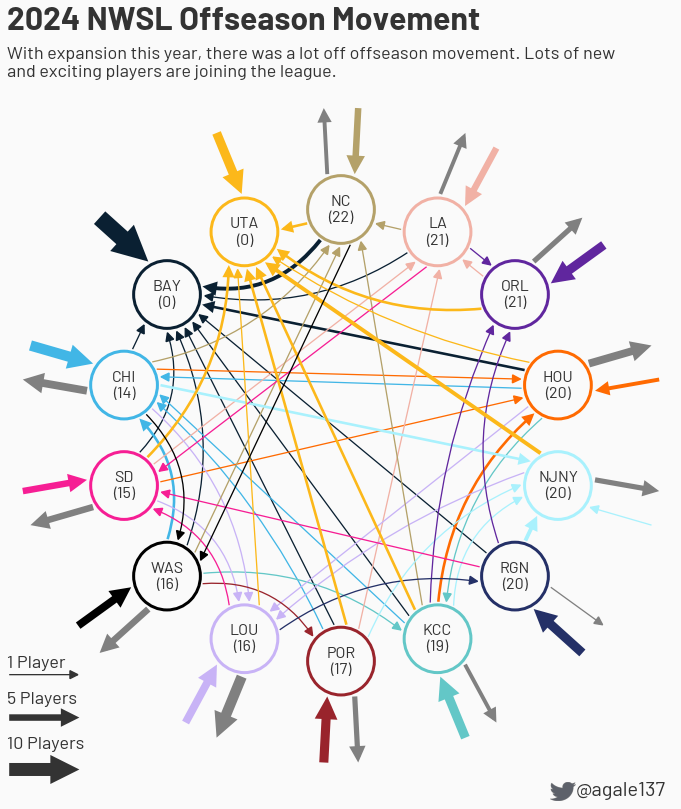

In [10]:
# Constants
outer_radius = 0.3
outer_angle = math.pi / 8
circle_r = 0.15


def lw(n):
    """How to scale the line width based on a data value."""
    return 1.3 * n


# Draw the plot
plt.clf()
plt.rcParams["figure.figsize"] = (10, 10)
plt.figure(dpi=1600)
fig, ax = plt.subplots()
fig.tight_layout()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)
ax.axis("off")

# Set limits
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

angles = {}
indices = {}


def get_coords(team, r=1):
    angle = angles[team]
    return (math.sin(angle) * r, math.cos(angle) * r)


def move_point_along_line(x1, y1, x2, y2, r):
    """Moves point (x1, y1) a distance r towards (x2, y2)"""

    d = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    t = r / d

    return ((1 - t) * x1 + t * x2, (1 - t) * y1 + t * y2)


def rotate_point(x1, y1, cx, cy, angle):
    """Rotates (x1, y1) around (cx, cy) by angle"""
    x = (x1 - cx) * math.cos(angle) - (y1 - cy) * math.sin(angle)
    y = (x1 - cx) * math.sin(angle) + (y1 - cy) * math.cos(angle)

    return (x + cx, y + cy)


# Plot teams
for i, team in retained.iterrows():
    angle = i * math.pi / 7
    angles[team["team_new"]] = angle
    indices[team["team_new"]] = i
    x, y = get_coords(team["team_new"])
    width = lw(team["count"])
    r = circle_r - width / 550
    ax.add_patch(
        patches.Circle(
            (x, y), circle_r, ec=NWSL.color(team["team_new"]), color=Colors.WHITE, lw=3
        )
    )
    ax.text(
        x,
        y,
        team["team_new"] + "\n(" + str(team["count"]) + ")",
        ha="center",
        va="center",
        size=16,
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
    )

# Plot players who joined the league
for i, team in new.iterrows():
    r = circle_r + 0.01
    cx, cy = get_coords(team["team_new"], 1)
    x2, y2 = get_coords(team["team_new"], r + 1)
    color = NWSL.color(team["team_new"])

    x2a, y2a = rotate_point(x2, y2, cx, cy, -outer_angle)
    x1a, y1a = move_point_along_line(0, 0, x2a, y2a, r + 1 + outer_radius)

    ax.add_patch(
        patches.FancyArrowPatch(
            (x1a, y1a),
            (x2a, y2a),
            arrowstyle="-|>",
            lw=lw(team["count"]),
            mutation_scale=20,
            joinstyle="miter",
            capstyle="butt",
            clip_on=False,
            color=color,
            fc=color,
        )
    )

# Plot players who left the league
for i, team in old.iterrows():
    r = circle_r + 0.01
    cx, cy = get_coords(team["team_old"], 1)
    x1, y1 = get_coords(team["team_old"], r + 1)
    color = "gray"

    x1a, y1a = rotate_point(x1, y1, cx, cy, outer_angle)
    x2a, y2a = move_point_along_line(0, 0, x1a, y1a, r + 1 + outer_radius)

    ax.add_patch(
        patches.FancyArrowPatch(
            (x1a, y1a),
            (x2a, y2a),
            arrowstyle="-|>",
            lw=lw(team["count"]),
            mutation_scale=20,
            joinstyle="miter",
            capstyle="butt",
            clip_on=False,
            color=color,
            fc=color,
        )
    )

# Plot movement between teams
for i, team in traded.iterrows():
    cx1, cy1 = get_coords(team["team_old"], 1)
    x1, y1 = get_coords(team["team_old"], 1 - circle_r - 0.005)
    cx2, cy2 = get_coords(team["team_new"], 1)
    x2, y2 = get_coords(team["team_new"], 1 - circle_r - 0.005)

    # Rotate based on angles
    dist = min(
        (indices[team["team_new"]] - indices[team["team_old"]]) % len(teams),
        (indices[team["team_old"]] - indices[team["team_new"]]) % len(teams),
    )
    clockwise = ((indices[team["team_new"]] - indices[team["team_old"]]) % len(teams)) < (
        (indices[team["team_old"]] - indices[team["team_new"]]) % len(teams)
    )
    r1, r2 = (0, 0)
    if dist == 1:
        sign = 1 if clockwise else -1
        r1, r2 = (
            sign * math.pi * (7 / 8) / 2 + math.pi / 16,
            sign * -math.pi * (7 / 8) / 2 - math.pi / 16,
        )
    else:
        r1, r2 = get_angles(team["team_old"], team["team_new"])

    x1a, y1a = rotate_point(x1, y1, cx1, cy1, r1)
    x2a, y2a = rotate_point(x2, y2, cx2, cy2, r2)

    color = NWSL.color(team["team_new"])

    connectionstyle = "arc3,rad=0"

    if dist > 1 and dist < 5:
        angle = "0." + str(5 - dist)
        sign = "" if clockwise else "-"
        connectionstyle = "arc3,rad=" + sign + angle

    ax.add_patch(
        patches.FancyArrowPatch(
            (x1a, y1a),
            (x2a, y2a),
            arrowstyle="-|>",
            connectionstyle=connectionstyle,
            lw=lw(team["count"]),
            mutation_scale=20,
            joinstyle="miter",
            capstyle="butt",
            clip_on=False,
            color=color,
            fc=color,
        )
    )

# Title
plt.title(
    "2024 NWSL Offseason Movement",
    fontproperties=Fonts.BARLOW_BOLD,
    size=32,
    x=0,
    y=1.09,
    ha="left",
    color=Colors.BLACK,
)

# Subtitle
fig.text(
    0,
    1.03,
    "With expansion this year, there was a lot off offseason movement. Lots of new\nand exciting players are joining the league.",
    fontproperties=Fonts.BARLOW,
    size=18,
    transform=ax.transAxes,
    ha="left",
    color=Colors.BLACK,
)

# Legend
lines = [1, 5, 10]
for i, l in enumerate(lines):
    x = -1.5
    y = -1 - (i * 0.2 if i > 0 else 0.04)
    ax.text(
        x,
        y,
        str(l) + " Player" + (" " if l == 1 else "s "),
        ha="left",
        va="bottom",
        fontsize=18,
        color=Colors.BLACK,
        fontproperties=Fonts.BARLOW,
    )
    ax.add_patch(
        patches.FancyArrowPatch(
            (x, y - 0.02 - i * 0.03),
            (x + 1 / len(lines), y - 0.02 - i * 0.03),
            arrowstyle="-|>",
            lw=lw(l),
            mutation_scale=20,
            joinstyle="miter",
            capstyle="butt",
            clip_on=False,
            color=Colors.BLACK,
            fc=Colors.BLACK,
        )
    )

# Twitter logo and username
add_twitter_handle(fig, x=0.8, y=0.0, fs=20, w=0.03)

# Save image
plt.savefig("images/2024_offseason.png", bbox_inches="tight", pad_inches=0.5, dpi=400)